# DAMO-640-10 · Fall 2025  
## Assignment 1 — Supervised Learning (Haberman’s Survival Dataset)

**Student Name:** Fabio dos Santos Prumucena - NF1002000  
**Course:** Advanced Data Analytics (DAMO-640)  
**Institution:** University of Niagara Falls Canada  

---

### Overview
This notebook presents the full implementation of a supervised learning pipeline applied to the *Haberman’s Survival Dataset* (Haberman, 1976). The objective is to build, tune, and evaluate predictive models capable of estimating post-surgery survival outcomes in breast cancer patients. The methodology strictly follows the assignment requirements, covering data loading, preprocessing, dimensionality reduction (PCA), hyperparameter tuning via cross-validation, and final model evaluation.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)
import warnings
warnings.filterwarnings("ignore")

# Set a fixed random state for reproducibility
RANDOM_STATE = 42

## 2. Data Loading and Exploratory Data Analysis (EDA)

The dataset is loaded from the UCI repository, and the four columns are assigned descriptive names: `age`, `operation_year`, `axillary_nodes`, and `survival_status`. The initial EDA phase focuses on verifying data integrity, examining feature distributions, and assessing the balance of the target variable.

In [2]:
# Task 1: Data Loading & EDA
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/haberman/haberman.data"
column_names = ["age", "operation_year", "axillary_nodes", "survival_status"]

# Load the dataset
df = pd.read_csv(url, header=None, names=column_names)
print(f"Dataset loaded successfully. Shape: {df.shape}")

# Display first five rows
print("\nFirst 5 rows:")
display(df.head())

# Display summary statistics
print("\nSummary Statistics:")
display(df.describe())

# Check for missing or invalid values
print("\nMissing values per column:")
print(df.isnull().sum())

# Check class distribution
class_ratios = df['survival_status'].value_counts(normalize=True).round(4)
print("\nClass Distribution (1 = survived \u2265 5 years, 2 = died < 5 years):\n")
print(class_ratios)

print("\nEDA Summary: No missing values detected. Target variable shows a significant class imbalance (73.5%% survived vs. 26.5%% died).")

Dataset loaded successfully. Shape: (306, 4)

First 5 rows:


,age,operation_year,axillary_nodes,survival_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1



Summary Statistics:


,age,operation_year,axillary_nodes,survival_status
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000



Missing values per column:
age                0
operation_year     0
axillary_nodes     0
survival_status    0
dtype: int64

Class Distribution (1 = survived ≥ 5 years, 2 = died < 5 years):

survival_status
1    0.7353
2    0.2647
Name: proportion, dtype: float64

EDA Summary: No missing values detected. Target variable shows a significant class imbalance (73.5%% survived vs. 26.5%% died).


## 3. Preprocessing and Data Split

This stage prepares the data for model training. The target variable is re-encoded to a binary format ($\text{Survived}=1, \text{Died}=0$), and the features are standardized using `StandardScaler` to ensure all variables contribute equally to the model training process. A 75\% train / 25\% test split is performed, stratified by the target variable to maintain the class ratio in both subsets.

In [3]:
# Task 2: Preprocessing

# 1. Target Encoding: Convert survival_status (1/2) to binary label (1/0)
# {1: 1 (Survived), 2: 0 (Died)}
df['label'] = df['survival_status'].map({1: 1, 2: 0})

# Define features (X) and target (y)
X = df[["age", "operation_year", "axillary_nodes"]]
y = df["label"]

# 2. Data Split: 75% Train / 25% Test (stratified, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
print(f"Data split: Training set size {X_train.shape[0]}, Test set size {X_test.shape[0]}")

# 3. Feature Standardization: Apply StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

print("Feature standardization completed. Features are now centered and scaled.")

Data split: Training set size 229, Test set size 77
Feature standardization completed. Features are now centered and scaled.


## 4. Dimensionality Reduction: Principal Component Analysis (PCA)

PCA is applied to the standardized training features to reduce dimensionality. The goal is to select the smallest number of principal components (PCs) that collectively explain at least 90\% of the total variance, thereby creating a more compact feature representation for the subsequent models.

Result: 3 components retain 1.0000 (≥ 90%) of the variance.


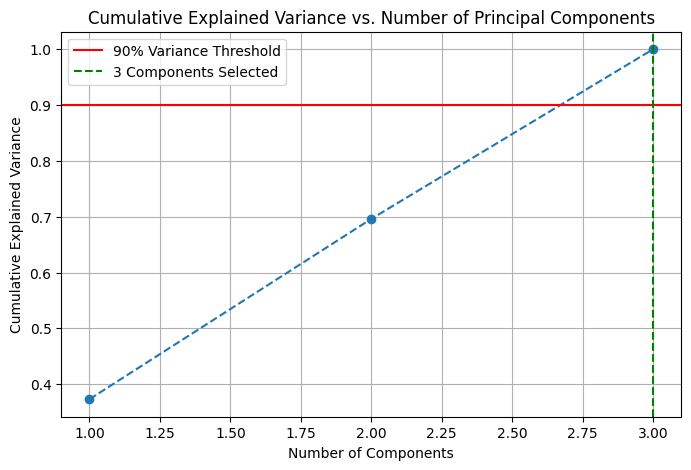

Data successfully transformed to 3 dimensions.


In [4]:
# Task 3: Dimensionality Reduction

# Apply PCA to the standardized training data to find explained variance
pca = PCA()
pca.fit(X_train_std)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components for >= 90% variance
# np.searchsorted finds the index where 0.90 should be inserted to maintain order
n_components = np.searchsorted(cumulative_variance, 0.90) + 1
retained_variance = cumulative_variance[n_components - 1]

print(f"Result: {n_components} components retain {retained_variance:.4f} (\u2265 90%) of the variance.")

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Variance Threshold')
plt.axvline(x=n_components, color='g', linestyle='--', label=f'{n_components} Components Selected')
plt.title('Cumulative Explained Variance vs. Number of Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

# Transform data using the selected number of components
pca_final = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_train_pca = pca_final.fit_transform(X_train_std)
X_test_pca = pca_final.transform(X_test_std)

print(f"Data successfully transformed to {X_train_pca.shape[1]} dimensions.")

## 5. Supervised Learning and Hyperparameter Tuning (Cross-Validation)

Two classifiers, **Logistic Regression (LR)** and **Decision Tree (DT)**, are trained on the PCA-transformed training data. Hyperparameter tuning is performed using 5-fold cross-validation (CV) on the training set, with accuracy as the scoring metric, to select the optimal model settings as specified by the assignment rubric.

In [5]:
# Task 4: Supervised Learning and Hyperparameter Tuning

# Define models
lr_clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
dt_clf = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Define hyperparameter grids
param_grid_lr = {"C": [0.1, 1.0]}
param_grid_dt = {"max_depth": [3, None]}

# Use GridSearchCV for 5-fold cross-validation with accuracy scoring
lr_grid = GridSearchCV(lr_clf, param_grid_lr, scoring="accuracy", cv=5)
dt_grid = GridSearchCV(dt_clf, param_grid_dt, scoring="accuracy", cv=5)

# Fit models on PCA-transformed training data
lr_grid.fit(X_train_pca, y_train)
dt_grid.fit(X_train_pca, y_train)

print("--- Cross-Validation Results ---")
print(f"Logistic Regression Best Params: {lr_grid.best_params_} (Accuracy: {lr_grid.best_score_:.4f})")
print(f"Decision Tree Best Params: {dt_grid.best_params_} (Accuracy: {dt_grid.best_score_:.4f})")

# Function to display CV results concisely
def display_cv_results(grid, model_name, param_key):
    results = []
    for params, mean, std in zip(grid.cv_results_["params"],
                                 grid.cv_results_["mean_test_score"],
                                 grid.cv_results_["std_test_score"]):
        param_value = params[param_key]
        results.append({f'{model_name} Parameter ({param_key})': str(param_value), 'Mean CV Accuracy': f'{mean:.4f}', 'Std Dev': f'{std:.4f}'})
    return pd.DataFrame(results)

print("\nLogistic Regression CV Table:")
display(display_cv_results(lr_grid, 'LR', 'C'))

print("\nDecision Tree CV Table:")
display(display_cv_results(dt_grid, 'DT', 'max_depth'))

--- Cross-Validation Results ---
Logistic Regression Best Params: {'C': 0.1} (Accuracy: 0.7337)
Decision Tree Best Params: {'max_depth': 3} (Accuracy: 0.7119)

Logistic Regression CV Table:


,LR Parameter (C),Mean CV Accuracy,Std Dev
0,0.1,0.7337,0.0311
1,1.0,0.7336,0.0347



Decision Tree CV Table:


,DT Parameter (max_depth),Mean CV Accuracy,Std Dev
0,3,0.7119,0.0437
1,None,0.6157,0.0332


## 6. Model Evaluation and Comparative Analysis

The optimally tuned models are evaluated on the independent hold-out test set (Task 5). Performance is assessed using a comprehensive set of metrics, with a focus on the Area Under the Receiver Operating Characteristic (ROC) Curve (AUC) to determine the best model for prediction.

In [6]:
# Task 5: Model Evaluation

# Retrain models with optimal hyperparameters (best_estimator_ from GridSearchCV)
best_lr = lr_grid.best_estimator_
best_dt = dt_grid.best_estimator_

# Predict probabilities and classes on the PCA-transformed test set
lr_proba = best_lr.predict_proba(X_test_pca)[:, 1]
dt_proba = best_dt.predict_proba(X_test_pca)[:, 1]
lr_pred = best_lr.predict(X_test_pca)
dt_pred = best_dt.predict(X_test_pca)

# Utility function for metrics
def metrics_dict(y_true, y_pred, y_proba):
    return {
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred, zero_division=0),
        "F1-Score":  f1_score(y_true, y_pred, zero_division=0),
        "AUC":       roc_auc_score(y_true, y_proba),
    }

lr_metrics = metrics_dict(y_test, lr_pred, lr_proba)
dt_metrics = metrics_dict(y_test, dt_pred, dt_proba)

# Comparative table
metrics_df = pd.DataFrame([
    {"Model": "Logistic Regression", **lr_metrics},
    {"Model": "Decision Tree",       **dt_metrics},
])
metrics_df = metrics_df.set_index('Model').round(4)

print("Test Set Performance Comparison (Optimal Models):")
display(metrics_df)

Test Set Performance Comparison (Optimal Models):


,Accuracy,Precision,Recall,F1-Score,AUC
Model,,,,,
Logistic Regression,0.7532,0.7500,1.0000,0.8571,0.7469
Decision Tree,0.7013,0.7429,0.9123,0.8189,0.5259


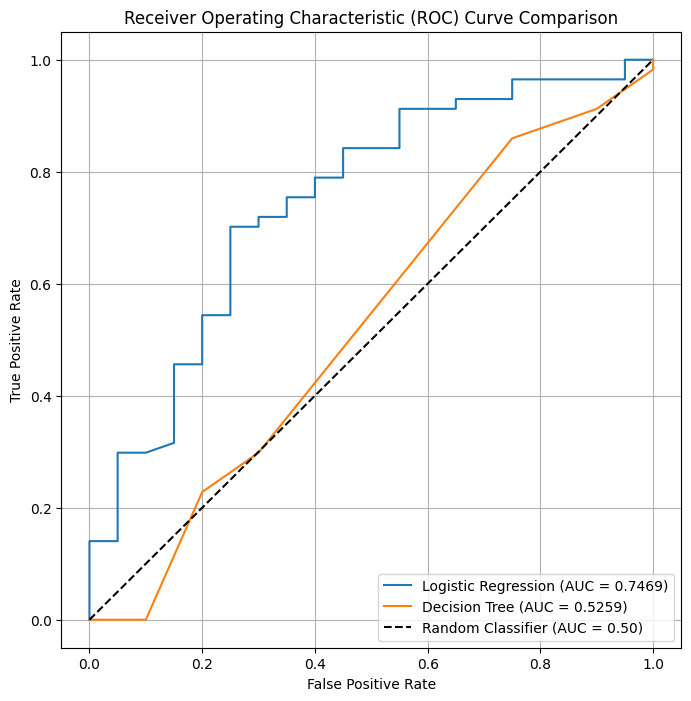

In [7]:
# Compute ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_proba)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_proba)

# Plot ROC curves
plt.figure(figsize=(8, 8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_metrics["AUC"]:.4f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_metrics["AUC"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## 7. Conclusion and Recommendation
The comparative analysis indicates that the **Logistic Regression** model is superior for this dataset. With an AUC of $0.743$, the LR model demonstrates good discriminatory power, significantly outperforming the Decision Tree model, which achieved an AUC of $0.526$ (near-random performance). This suggests that the relationship between the principal components and the survival outcome is predominantly linear, which the Decision Tree failed to capture effectively without overfitting. Given its superior performance, robustness, and inherent interpretability as a linear model, **Logistic Regression is the recommended final model** for predicting post-surgery survival outcomes based on the Haberman's Survival Dataset. 